In [1]:
from typing import List, Tuple, Dict, Any, Optional
from pandarallel import pandarallel
import os
import re
import sys
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import dspy
from pathlib import Path

# Read the groq token
GROQ_TOKEN = Path("../groq_token.txt").read_text().strip()
os.environ["GROQ_API_KEY"] = GROQ_TOKEN

# read the gemini token
GEMINI_TOKEN = Path("../gemini_token.txt").read_text().strip()
os.environ["GEMINI_API_KEY"] = GEMINI_TOKEN

# read the openai token
OPENAI_TOKEN = Path("../openai_token.txt").read_text().strip()
os.environ["OPENAI_API_KEY"] = OPENAI_TOKEN

lm = dspy.LM('groq/llama-3.3-70b-versatile')
# lm = dspy.LM('gemini/gemini-1.5-flash')
# lm = dspy.LM('openai/gpt-4o-mini')
dspy.configure(lm=lm)

## Token Cost Analysis

In [31]:

class CheckCitationFaithfulness(dspy.Signature):
    """Verify that the text is based on the provided context."""

    context: str = dspy.InputField(desc="facts here are assumed to be true")
    text: str = dspy.InputField()
    faithfulness: bool = dspy.OutputField()
    evidence: dict[str, list[str]] = dspy.OutputField(
        desc="Supporting evidence for claims")


context = "The 21-year-old made seven appearances for the Hammers and netted his only goal for them in a Europa League qualification round match against Andorran side FC Lustrains last season. Lee had two loan spells in League One last term, with Blackpool and then Colchester United. He scored twice for the U's but was unable to save them from relegation. The length of Lee's contract with the promoted Tykes has not been revealed. Find all the latest football transfers on our dedicated page."

text = "Lee scored 3 goals in total."

faithfulness = dspy.ChainOfThought(CheckCitationFaithfulness)
response = faithfulness(context=context, text=text)
faithfulness: bool = response.faithfulness
evidence: dict[str, list[str]] = response.evidence

print(f"Faithfulness: {faithfulness}")
print(f"Evidence: {evidence}")

Faithfulness: True
Evidence: {'claims': ['Lee scored 3 goals in total'], 'supporting evidence': ['Lee netted his only goal for the Hammers', "He scored twice for the U's"]}


In [32]:
lm.history

[{'prompt': None,
  'messages': [{'role': 'system',
    'content': 'Your input fields are:\n1. `context` (str): facts here are assumed to be true\n2. `text` (str)\n\nYour output fields are:\n1. `reasoning` (str)\n2. `faithfulness` (bool)\n3. `evidence` (dict[str, list[str]]): Supporting evidence for claims\n\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## context ## ]]\n{context}\n\n[[ ## text ## ]]\n{text}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## faithfulness ## ]]\n{faithfulness}        # note: the value you produce must be True or False\n\n[[ ## evidence ## ]]\n{evidence}        # note: the value you produce must be pareseable according to the following JSON schema: {"type": "object", "additionalProperties": {"type": "array", "items": {"type": "string"}}}\n\n[[ ## completed ## ]]\n\nIn adhering to this structure, your objective is: \n        Verify that the text is based on the provided context.'},
   {'role': 'user',


In [34]:
lm.history[-1]["usage"]

'2025-01-16T17:15:35.919508'

In [37]:
GENERATION_DIR = "../program_bank/v018/2025_01_16__17_19__qiskit"

json_files = list(Path(GENERATION_DIR).rglob("*_metadata.json"))

df_metadata = pd.DataFrame.from_records(
    [json.loads(f.read_text()) for f in json_files])

df_metadata.head()
# Columns to denormalize
columns_to_denormalize = ['llm_usage', 'api_info', 'dspy_store']

# Loop through each column and denormalize
for column in columns_to_denormalize:
    df_normalized = pd.json_normalize(df_metadata[column])
    df_metadata = pd.concat(
        [df_metadata.drop(columns=[column]), df_normalized], axis=1)

df_metadata.head()

,llm_timestamp,llm_model,completion_tokens,prompt_tokens,total_tokens,api_name,full_api_name,api_description,api_signature,file_path,reasoning,generated_python_program,variable_name_of_circuit
0,2025-01-16T17:19:47.856264,groq/llama-3.3-70b-versatile,202,572,774,build_current_scope,QASM3Builder.build_current_scope,Build the instructions that occur in the curre...,build_current_scope(self),/usr/local/lib/python3.10/site-packages/qiskit...,To generate a program inspired by the QASM3Bui...,from qiskit import QuantumCircuit\nfrom qiskit...,circuit
1,2025-01-16T17:25:53.685554,groq/llama-3.3-70b-versatile,189,545,734,__array__,PauliList.__array__,Convert to numpy array,"__array__(self, dtype, copy)",/usr/local/lib/python3.10/site-packages/qiskit...,The provided API is a method of the PauliList ...,from qiskit import QuantumCircuit\nfrom qiskit...,qc
2,2025-01-16T17:19:34.667011,groq/llama-3.3-70b-versatile,179,533,712,_dumps_register,_dumps_register,,"_dumps_register(register, index_map)",/usr/local/lib/python3.10/site-packages/qiskit...,The function _dumps_register is used to serial...,"from qiskit import QuantumCircuit, QuantumRegi...",qc
3,2025-01-16T17:29:26.752382,groq/llama-3.3-70b-versatile,241,540,781,_unroll_param_dict,QuantumCircuit._unroll_param_dict,,"_unroll_param_dict(self, parameter_binds)",/usr/local/lib/python3.10/site-packages/qiskit...,The given API is QuantumCircuit._unroll_param_...,from qiskit import QuantumCircuit\nfrom qiskit...,qc
4,2025-01-16T17:28:06.178445,groq/llama-3.3-70b-versatile,255,528,783,__str__,Bloch.__str__,,__str__(self),/usr/local/lib/python3.10/site-packages/qiskit...,To generate a program inspired by the Bloch.__...,from qiskit import QuantumCircuit\nfrom qiskit...,qc


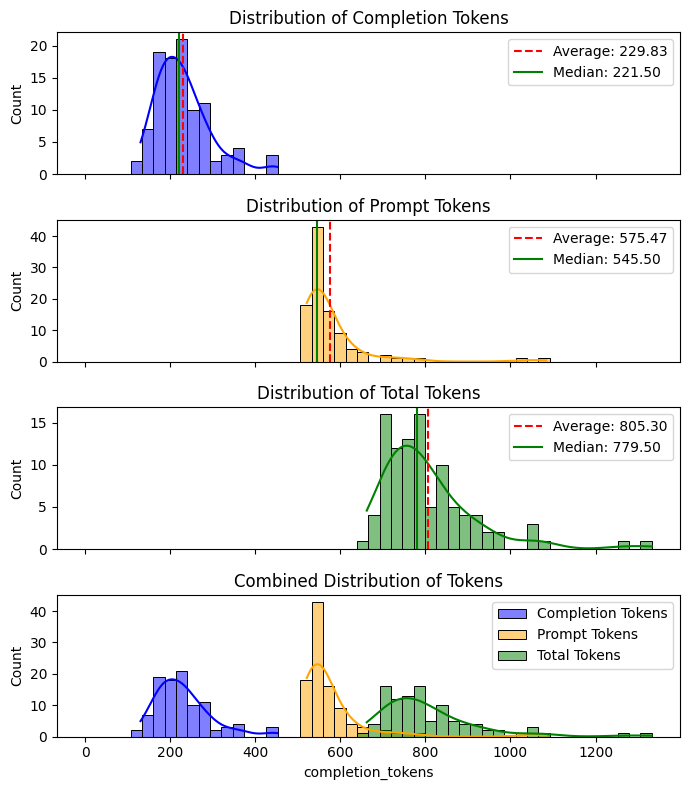

In [47]:
# Plotting the distribution of completion_tokens, prompt_tokens, and total_tokens
fig, axs = plt.subplots(4, 1, figsize=(7, 8), sharex=True)

bin_width = df_metadata['total_tokens'].max() / 50
bins = np.arange(0, df_metadata['total_tokens'].max() + bin_width, bin_width)


def plot_distribution_with_stats(ax, data, color, title, bins):
    sns.histplot(data, kde=True, ax=ax, color=color, bins=bins)
    ax.set_title(title)
    avg = data.mean()
    median = data.median()
    ax.axvline(avg, color='red', linestyle='--', label=f'Average: {avg:.2f}')
    ax.axvline(median, color='green', linestyle='-',
               label=f'Median: {median:.2f}')
    ax.legend()


# Plot for completion_tokens
plot_distribution_with_stats(
    axs[0],
    df_metadata['completion_tokens'],
    'blue', 'Distribution of Completion Tokens', bins)

# Plot for prompt_tokens
plot_distribution_with_stats(
    axs[1],
    df_metadata['prompt_tokens'],
    'orange', 'Distribution of Prompt Tokens', bins)

# Plot for total_tokens
plot_distribution_with_stats(
    axs[2],
    df_metadata['total_tokens'],
    'green', 'Distribution of Total Tokens', bins)

# Combined plot

sns.histplot(
    df_metadata['completion_tokens'],
    kde=True, ax=axs[3],
    color='blue', label='Completion Tokens', bins=bins)
sns.histplot(
    df_metadata['prompt_tokens'],
    kde=True, ax=axs[3],
    color='orange', label='Prompt Tokens', bins=bins)
sns.histplot(
    df_metadata['total_tokens'],
    kde=True, ax=axs[3],
    color='green', label='Total Tokens', bins=bins)
axs[3].set_title('Combined Distribution of Tokens')
axs[3].legend()

plt.tight_layout()
plt.show()

In [48]:
dspy.__dict__

{'__name__': 'dspy',
 '__doc__': None,
 '__package__': 'dspy',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f220117d300>,
 '__spec__': ModuleSpec(name='dspy', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f220117d300>, origin='/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/dspy/__init__.py', submodule_search_locations=['/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/dspy']),
 '__path__': ['/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/dspy'],
 '__file__': '/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/dspy/__init__.py',
 '__cached__': '/home/paltenmo/.conda/envs/crosspl/lib/python3.10/site-packages/dspy/__pycache__/__init__.cpython-310.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importli

In [53]:
dspy.settings["lm"].history

[{'prompt': None,
  'messages': [{'role': 'system',
    'content': 'Your input fields are:\n1. `context` (str): facts here are assumed to be true\n2. `text` (str)\n\nYour output fields are:\n1. `reasoning` (str)\n2. `faithfulness` (bool)\n3. `evidence` (dict[str, list[str]]): Supporting evidence for claims\n\nAll interactions will be structured in the following way, with the appropriate values filled in.\n\n[[ ## context ## ]]\n{context}\n\n[[ ## text ## ]]\n{text}\n\n[[ ## reasoning ## ]]\n{reasoning}\n\n[[ ## faithfulness ## ]]\n{faithfulness}        # note: the value you produce must be True or False\n\n[[ ## evidence ## ]]\n{evidence}        # note: the value you produce must be pareseable according to the following JSON schema: {"type": "object", "additionalProperties": {"type": "array", "items": {"type": "string"}}}\n\n[[ ## completed ## ]]\n\nIn adhering to this structure, your objective is: \n        Verify that the text is based on the provided context.'},
   {'role': 'user',


## Using Migration

In [4]:
# GEMINI 30 programs
# GENERATION_DIR = "../program_bank/v018/2025_01_16__23_37__qiskit"

# GEMINI 300 programs -- high validity
# GENERATION_DIR = "../program_bank/v018/2025_01_17__00_38__qiskit"
GEN_GEMINI_FULL_DOC = "../program_bank/v018/2025_01_17__00_38__qiskit"

# LLAMA 3.3 70B 30 programs -- summarized migration documentation
# GENERATION_DIR = "../program_bank/v019/2025_01_17__11_46__qiskit"

# LLAMA 3.3 70B 300 programs  -- summarized migration documentation
# GENERATION_DIR = "../program_bank/v019/2025_01_17__12_06__qiskit"
GEN_LLAMA_SUMMARIZED = "../program_bank/v019/2025_01_17__12_06__qiskit"

GEN_GPT4OMINI_SUMMARIZED = "../program_bank/v020/2025_01_17__17_13__qiskit"
GEN_GEMINI_SUMMARIZED = "../program_bank/v021/2025_01_17__16_56__qiskit"


def generate_df_from_path(generation_dir: str) -> pd.DataFrame:
    json_files = list(Path(generation_dir).rglob("*_metadata.json"))

    def load_metadata(file: Path) -> Dict[str, Any]:
        data = json.loads(file.read_text())
        data['file'] = file
        return data

    df_metadata = pd.DataFrame.from_records(
        [load_metadata(f) for f in json_files])

    df_metadata["filename"] = df_metadata["file"].apply(lambda x: x.name)

    # Unpack execution_feedback column
    execution_feedback_df = pd.json_normalize(
        df_metadata['execution_feedback'])
    # Ensure there are at least three columns in execution_feedback_df
    while execution_feedback_df.shape[1] < 3:
        execution_feedback_df[f'execution_feedback_{execution_feedback_df.shape[1] + 1}'] = None

    # Rename columns to have _1, _2, _3 suffixes
    execution_feedback_df.columns = [
        f"execution_feedback_{i+1}"
        for i in range(execution_feedback_df.shape[1])]
    print(execution_feedback_df.columns)

    # Concatenate the unpacked columns back to the original dataframe
    df_metadata = pd.concat(
        [df_metadata,
         execution_feedback_df],
        axis=1)

    # for each new column, pick the value of "fixed" key and use it for the cell, note some cells have None, leave it
    for col in execution_feedback_df.columns:
        df_metadata[col] = df_metadata[col].apply(
            lambda x: x.get('fixed') if x is not None else None)

    # Rename columns
    df_metadata.rename(columns={
        'execution_feedback_1': 'gen_1_run_new',
        'execution_feedback_2': 'gen_1_run_old',
        'execution_feedback_3': 'gen_2_run_new'
    }, inplace=True)

    # Replace the values in the columns gen_1_run_new, gen_1_run_old, gen_2_run_new
    # Define the mapping once
    mapping = {True: 1, False: 0, None: -1}

    df_metadata['gen_1_run_new'] = df_metadata['gen_1_run_new'].map(mapping)
    df_metadata['gen_1_run_old'] = df_metadata['gen_1_run_old'].map(mapping)
    df_metadata['gen_2_run_new'] = df_metadata['gen_2_run_new'].map(mapping)

    # Create a new column 'cluster_label' by concatenating the values in the first three columns
    df_metadata['cluster_label'] = df_metadata.apply(
        lambda row: f"{int(row['gen_1_run_new'])},{int(row['gen_1_run_old']) if not pd.isna(row['gen_1_run_old']) else -1},{int(row['gen_2_run_new']) if not pd.isna(row['gen_2_run_new']) else -1}", axis=1)

    # Define the mapping for the labels
    label_mapping = {
        '1,-1,-1': 'right first attempt',
        '0,1,1': 'outdated but successful migration',
        '0,1,0': 'outdated failed migration',
        '0,0,-1': 'flawed logic'
    }

    # Map the cluster labels to the descriptive labels
    df_metadata['cluster_label'] = df_metadata['cluster_label'].map(
        label_mapping).fillna('other')

    return df_metadata


df_metadata_gemini_full = generate_df_from_path(GEN_GEMINI_FULL_DOC)
df_metadata_llama_summarized = generate_df_from_path(GEN_LLAMA_SUMMARIZED)
df_metadata_gpt4omini_summarized = generate_df_from_path(
    GEN_GPT4OMINI_SUMMARIZED)
df_metadata_gemini_summarized = generate_df_from_path(GEN_GEMINI_SUMMARIZED)

Index(['execution_feedback_1', 'execution_feedback_2', 'execution_feedback_3'], dtype='object')
Index(['execution_feedback_1', 'execution_feedback_2', 'execution_feedback_3'], dtype='object')
Index(['execution_feedback_1', 'execution_feedback_2', 'execution_feedback_3'], dtype='object')
Index(['execution_feedback_1', 'execution_feedback_2', 'execution_feedback_3'], dtype='object')


Gemini Full


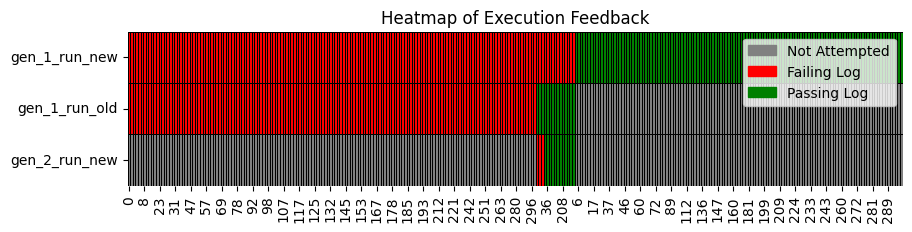

LLAMA Summarized


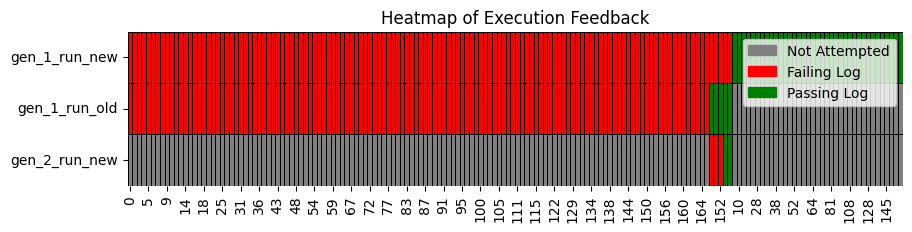

GPT4OMini Summarized


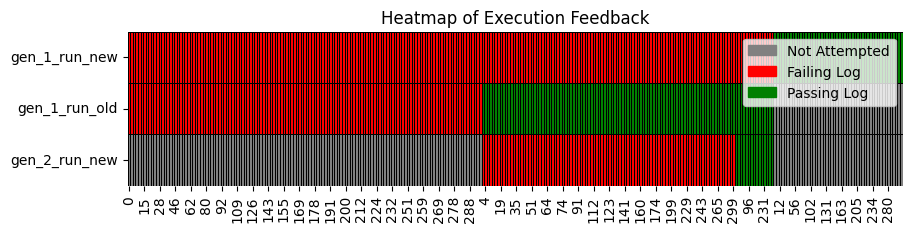

Gemini Summarized


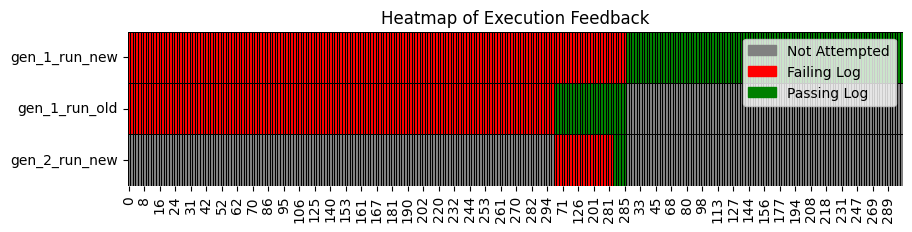

In [5]:
from matplotlib.patches import Patch


def show_success_heatmap(df_metadata: pd.DataFrame):
    # Plot heatmap of gen_1_run_new, gen_1_run_old, gen_2_run_new
    heatmap_data = df_metadata[['gen_1_run_new',
                                'gen_1_run_old', 'gen_2_run_new']]

    # Sort the rows
    heatmap_data = heatmap_data.sort_values(
        by=['gen_1_run_new', 'gen_1_run_old', 'gen_2_run_new'])

    # Define a custom color palette
    cmap = sns.color_palette(['gray', 'red', 'green'])

    plt.figure(figsize=(10, 2))
    sns.heatmap(heatmap_data.T, cmap=cmap, cbar=False,
                linewidths=0.5, linecolor='black')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.title('Heatmap of Execution Feedback')

    # Add legend
    legend_labels = {
        'gray': 'Not Attempted',
        'red': 'Failing Log',
        'green': 'Passing Log'
    }
    handles = [Patch(color=color, label=label)
               for color, label in legend_labels.items()]
    plt.legend(handles=handles, loc='upper right')

    plt.show()


# Call the function
print("Gemini Full")
show_success_heatmap(df_metadata=df_metadata_gemini_full)

print("LLAMA Summarized")
show_success_heatmap(df_metadata=df_metadata_llama_summarized)

print("GPT4OMini Summarized")
show_success_heatmap(df_metadata=df_metadata_gpt4omini_summarized)

print("Gemini Summarized")
show_success_heatmap(df_metadata=df_metadata_gemini_summarized)

Gemini Full


/tmp/ipykernel_666647/1057676408.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


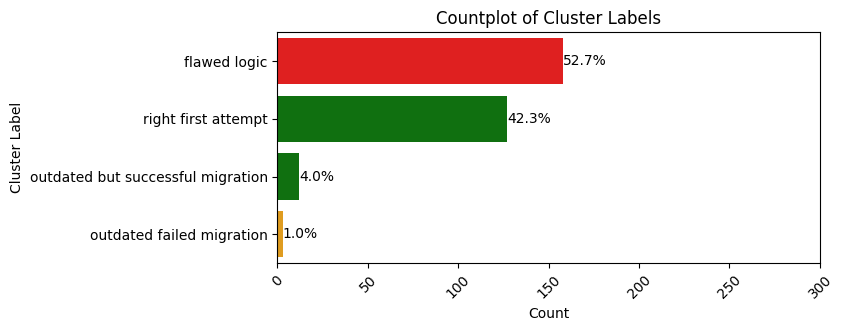

LLAMA Summarized


/tmp/ipykernel_666647/1057676408.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


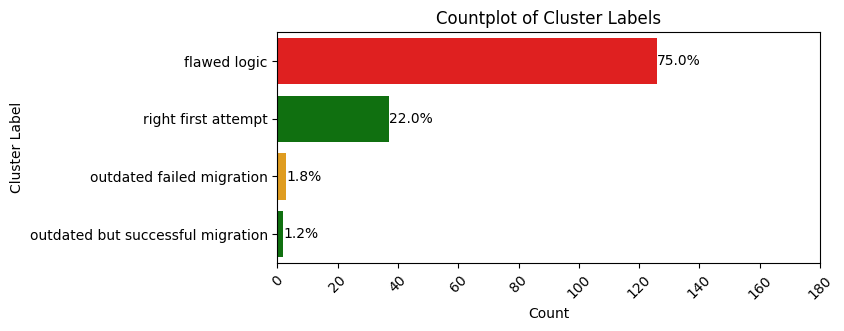

GPT4OMini Summarized


/tmp/ipykernel_666647/1057676408.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


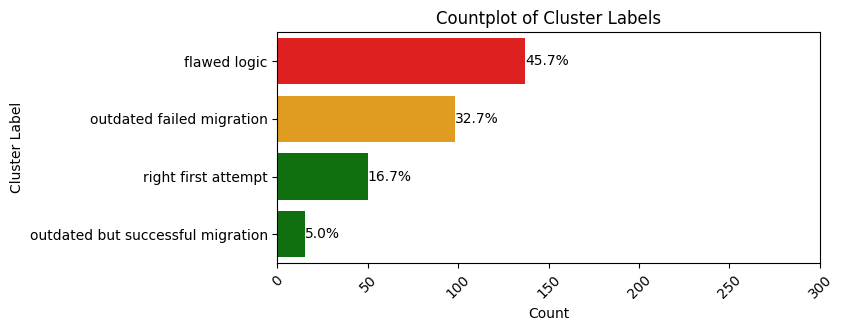

Gemini Summarized


/tmp/ipykernel_666647/1057676408.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


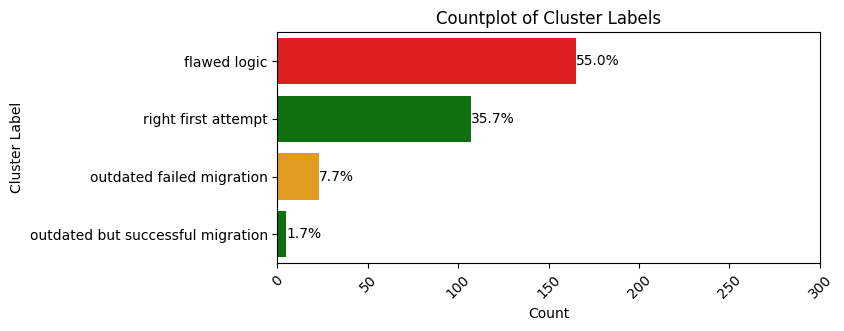

In [ ]:
def show_success_metrics(df_metadata: pd.DataFrame, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 3))

    # Create a new column 'cluster_label' by concatenating the values in the first three columns
    df_metadata['cluster_label'] = df_metadata.apply(
        lambda row: f"{int(row['gen_1_run_new'])},{int(row['gen_1_run_old']) if not pd.isna(row['gen_1_run_old']) else -1},{int(row['gen_2_run_new']) if not pd.isna(row['gen_2_run_new']) else -1}", axis=1)

    # Define the mapping for the labels
    label_mapping = {
        '1,-1,-1': 'right first attempt',
        '0,1,1': 'outdated but successful migration',
        '0,1,0': 'outdated failed migration',
        '0,0,-1': 'flawed logic'
    }

    # Map the cluster labels to the descriptive labels
    df_metadata['cluster_label'] = df_metadata['cluster_label'].map(
        label_mapping).fillna('other')

    # Plot the countplot of the values of the 'cluster_label' column with custom colors
    colors = {
        'flawed logic': 'red',
        'outdated but successful migration': 'green',
        'right first attempt': 'green',
        'outdated failed migration': 'orange',
        'other': 'blue'
    }
    sns.countplot(
        data=df_metadata, y='cluster_label',
        order=df_metadata['cluster_label'].value_counts().index,
        palette=colors, ax=ax)
    ax.set_title('Countplot of Cluster Labels')
    ax.set_xlabel('Count')
    ax.set_ylabel('Cluster Label')
    # set the x-limit to the sum of the values
    n_data = len(df_metadata)
    ax.set_xlim(0, n_data)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Add percentage labels
    total = len(df_metadata)
    for p in ax.patches:
        percentage = f'{100 * p.get_width() / total:.1f}%'
        ax.annotate(
            percentage, (p.get_width(),
                         p.get_y() + p.get_height() / 2),
            ha='left', va='center')


# Call the function
print("Gemini Full")
show_success_metrics(df_metadata=df_metadata_gemini_full)
plt.show()

print("LLAMA Summarized")
show_success_metrics(df_metadata=df_metadata_llama_summarized)
plt.show()

print("GPT4OMini Summarized")
show_success_metrics(df_metadata=df_metadata_gpt4omini_summarized)
plt.show()

print("Gemini Summarized")
show_success_metrics(df_metadata=df_metadata_gemini_summarized)
plt.show()

In [17]:
from collections import defaultdict
from IPython.display import Markdown, display

k_sample = 15

# Group filenames by cluster label
cluster_files = defaultdict(list)
for label, group in df_metadata.groupby('cluster_label'):
    cluster_files[label] = group['filename'].tolist()

# Pick 15 representative filenames for each cluster
representative_files = {label: files[:k_sample]
                        for label, files in cluster_files.items()}

# Concatenate filenames into a regex pattern
regex_patterns = {label: '|'.join(files)
                  for label, files in representative_files.items()}


def pretty_print_python_code(code: str) -> str:
    formatted_code = f"```python\n{code}\n```"
    display(Markdown(formatted_code))
    return formatted_code


def get_log_output(
        metadata_filename: str, execution_feedback_id: int) -> Optional[str]:
    df_row = df_metadata[df_metadata['filename'] == metadata_filename]
    execution_feedback = df_row[f'execution_feedback'].values[0]
    if execution_feedback is not None:
        target_feedback = [
            feedback for feedback in execution_feedback
            if feedback['id'] == execution_feedback_id]
        if target_feedback:
            return target_feedback[0]['log']
    return None


# Print the regex patterns
for label, pattern in regex_patterns.items():
    display(Markdown(f"### Cluster: {label},"))
    print(f"Regex Pattern: {pattern}")
    filenames_metadata = cluster_files[label]
    filenames_py = [f.replace("_metadata.json", "_circuit.py")
                    for f in filenames_metadata]
    print(f"Sample Filenames: {filenames_py[:k_sample]}")
    for filename in filenames_py[:k_sample]:
        pretty_print_python_code(
            code=Path(f"{GENERATION_DIR}/{filename}").read_text())
        filename_metadata = filename.replace("_circuit.py", "_metadata.json")
        for exec_id in range(1, 4):
            log_output = get_log_output(filename_metadata, exec_id)
            if log_output:
                print(f"Log Output {exec_id}\n{log_output}")
        print("-" * 10)
    print("=" * 100)

### Cluster: flawed logic,

Regex Pattern: 0000048_439f45_metadata.json|0000080_9e8f25_metadata.json|0000020_4d2a3f_metadata.json|0000046_b9468f_metadata.json|0000053_b1c272_metadata.json|0000051_e19b9b_metadata.json|0000047_2484e8_metadata.json|0000073_774e38_metadata.json|0000044_24955b_metadata.json|0000049_1d29e2_metadata.json|0000019_83a5df_metadata.json|0000031_05fe67_metadata.json|0000014_c31cfa_metadata.json|0000069_e00238_metadata.json|0000068_1388f0_metadata.json
Sample Filenames: ['0000048_439f45_circuit.py', '0000080_9e8f25_circuit.py', '0000020_4d2a3f_circuit.py', '0000046_b9468f_circuit.py', '0000053_b1c272_circuit.py', '0000051_e19b9b_circuit.py', '0000047_2484e8_circuit.py', '0000073_774e38_circuit.py', '0000044_24955b_circuit.py', '0000049_1d29e2_circuit.py', '0000019_83a5df_circuit.py', '0000031_05fe67_circuit.py', '0000014_c31cfa_circuit.py', '0000069_e00238_circuit.py', '0000068_1388f0_circuit.py']


```python
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit.quantum_info.operators.channel import SuperOp
import numpy as np

qc = QuantumCircuit(1, 1)
qc.x(0)
qc.measure(0, 0)

# create a SuperOp object
superop = SuperOp(np.array([[1, 0], [0, 1]]))

# get the shape of the bipartite matrix
bipartite_shape = superop._bipartite_shape()

print(bipartite_shape)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 10, in <module>
    superop = SuperOp(np.array([[1, 0], [0, 1]]))
  File "/usr/local/lib/python3.10/site-packages/qiskit/quantum_info/operators/channel/superop.py", line 102, in __init__
    raise QiskitError("Invalid shape for SuperOp matrix.")
qiskit.exceptions.QiskitError: 'Invalid shape for SuperOp matrix.'

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 10, in <module>
    superop = SuperOp(np.array([[1, 0], [0, 1]]))
  File "/usr/local/lib/python3.10/site-packages/qiskit/quantum_info/operators/channel/superop.py", line 100, in __init__
    raise QiskitError("Invalid shape for SuperOp matrix.")
qiskit.exceptions.QiskitError: 'Invalid shape for SuperOp matrix.'

----------


```python
from qiskit.transpiler.passes.synthesis.unitary_synthesis import _build_gate_lengths_by_qubit
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeVigoV2

def generate_circuit():
    # Create a backend
    backend = FakeVigoV2()
    
    # Create a quantum circuit
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)
    
    # Transpile the circuit
    transpiled_circuit = transpile(circuit, backend)
    
    # Get the gate lengths
    gate_lengths = _build_gate_lengths_by_qubit(None, transpiled_circuit.target)
    
    # Print the gate lengths
    print(gate_lengths)
    
    return circuit

circuit = generate_circuit()
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 3, in <module>
    from qiskit.providers.fake_provider import FakeVigoV2
ImportError: cannot import name 'FakeVigoV2' from 'qiskit.providers.fake_provider' (/usr/local/lib/python3.10/site-packages/qiskit/providers/fake_provider/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 25, in <module>
    circuit = generate_circuit()
  File "/workspace/code_sample.py", line 18, in generate_circuit
    gate_lengths = _build_gate_lengths_by_qubit(None, transpiled_circuit.target)
AttributeError: 'QuantumCircuit' object has no attribute 'target'

----------


```python
from qiskit import QuantumCircuit, execute, assemble
from qiskit.compiler.assembler import assemble
from qiskit.providers.aer import AerSimulator

# Create a quantum circuit
circuit1 = QuantumCircuit(2)
circuit1.x(0)
circuit1.cx(0, 1)

# Create another quantum circuit
circuit2 = QuantumCircuit(2)
circuit2.x(1)
circuit2.cx(0, 1)

# Assemble the circuits into a Qobj
qobj = assemble([circuit1, circuit2], shots=1024)

# Create a simulator
backend = AerSimulator()

# Execute the Qobj
job = backend.run(qobj)

# Get the results
results = job.result()

print(results.get_counts())
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute, assemble
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
/workspace/code_sample.py:22: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job = backend.run(qobj)
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 27, in <module>
    print(results.get_counts())
  File "/usr/local/lib/python3.10/site-packages/qiskit/result/result.py", line 289, in get_counts
    raise QiskitError(f'No counts for experiment "{repr(key)}"')
qiskit.exceptions.QiskitError: 'No counts for experiment "0"'

----------


```python
from qiskit import QuantumCircuit
from qiskit.utils import LazyDependencyManager

def generate_circuit():
    circuit = QuantumCircuit(2)
    circuit.h(0)
    circuit.cx(0, 1)
    return circuit

circuit = generate_circuit()
dependency_manager = LazyDependencyManager()
if dependency_manager:
    print("Dependencies are met")
else:
    print("Dependencies are not met")
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 11, in <module>
    dependency_manager = LazyDependencyManager()
TypeError: Can't instantiate abstract class LazyDependencyManager with abstract method _is_available

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 11, in <module>
    dependency_manager = LazyDependencyManager()
TypeError: Can't instantiate abstract class LazyDependencyManager with abstract method _is_available

----------


```python
from qiskit.synthesis.discrete_basis.commutator_decompose import _compute_commutator_so3
import numpy as np
from qiskit import QuantumCircuit

# Create two SO(3)-matrices
a = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
b = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]])

# Compute the commutator of a and b
commutator = _compute_commutator_so3(a, b)

# Create a QuantumCircuit object
qc = QuantumCircuit(3)

# Print the commutator
print(commutator)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 10, in <module>
    commutator = _compute_commutator_so3(a, b)
  File "/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/commutator_decompose.py", line 176, in _compute_commutator_so3
    _check_is_so3(b)
  File "/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/gate_sequence.py", line 415, in _check_is_so3
    raise ValueError(f"Determinant of matrix must be 1, but is {np.linalg.det(matrix)}.")
ValueError: Determinant of matrix must be 1, but is 0.0.

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 10, in <module>
    commutator = _compute_commutator_so3(a, b)
  File "/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/commutator_decompose.py", line 176, in _compute_commutator_so3
    _check_is_so3(b)
  File "/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/gate_sequence.

```python
from qiskit.visualization.timeline import drawings
import qiskit
from qiskit import QuantumCircuit

def create_elementary_data():
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)
    return drawings.ElementaryData(qc)

def main():
    elem_data1 = create_elementary_data()
    elem_data2 = create_elementary_data()

    print(elem_data1 == elem_data2)

if __name__ == "__main__":
    main()
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 18, in <module>
    main()
  File "/workspace/code_sample.py", line 12, in main
    elem_data1 = create_elementary_data()
  File "/workspace/code_sample.py", line 9, in create_elementary_data
    return drawings.ElementaryData(qc)
TypeError: ElementaryData.__init__() missing 2 required positional arguments: 'xvals' and 'yvals'

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 18, in <module>
    main()
  File "/workspace/code_sample.py", line 12, in main
    elem_data1 = create_elementary_data()
  File "/workspace/code_sample.py", line 9, in create_elementary_data
    return drawings.ElementaryData(qc)
TypeError: ElementaryData.__init__() missing 2 required positional arguments: 'xvals' and 'yvals'

----------


```python
from qiskit import QuantumCircuit, PulseChannel
from qiskit.circuit.library import SdgGate

qc = QuantumCircuit(1)
qc.append(SdgGate(), [0])
print(qc.draw())
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, PulseChannel
ImportError: cannot import name 'PulseChannel' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, PulseChannel
ImportError: cannot import name 'PulseChannel' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

----------


```python
from qiskit import QuantumCircuit, TranspilerError
from qiskit.transpiler import TransformationPass

class CustomPass(TransformationPass):
    def run(self, circuit):
        circuit.h(0)
        self.update_status("Success")

qc = QuantumCircuit(1)
pass_instance = CustomPass()
pass_instance.run(qc)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, TranspilerError
ImportError: cannot import name 'TranspilerError' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, TranspilerError
ImportError: cannot import name 'TranspilerError' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

----------


```python
from qiskit.circuit.library import BlueprintCircuit
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

blueprint_circuit = BlueprintCircuit(circuit)
decomposed_circuit = blueprint_circuit.decompose(gates_to_decompose=['h', 'cx'], reps=1)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 8, in <module>
    blueprint_circuit = BlueprintCircuit(circuit)
TypeError: Can't instantiate abstract class BlueprintCircuit with abstract methods _build, _check_configuration

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 8, in <module>
    blueprint_circuit = BlueprintCircuit(circuit)
TypeError: Can't instantiate abstract class BlueprintCircuit with abstract methods _build, _check_configuration

----------


```python
from qiskit import QuantumCircuit, DAGCircuit
from qiskit.dagcircuit import DAGDepNode

def compare_nodes():
    # Create two Quantum Circuits
    circuit1 = QuantumCircuit(2)
    circuit1.h(0)
    circuit1.cx(0, 1)

    circuit2 = QuantumCircuit(2)
    circuit2.h(0)
    circuit2.cx(0, 1)

    # Convert to DAGCircuits
    dag1 = circuit1.to_dag()
    dag2 = circuit2.to_dag()

    # Get nodes from the DAGs
    node1 = dag1.nodes()[0]
    node2 = dag2.nodes()[0]

    # Compare the nodes using semantic_eq
    result = DAGDepNode.semantic_eq(node1, node2)
    print(f"Are the nodes equivalent? {result}")

    # Create another Quantum Circuit that is different
    circuit3 = QuantumCircuit(2)
    circuit3.x(0)
    circuit3.cx(0, 1)

    # Convert to DAGCircuit
    dag3 = circuit3.to_dag()

    # Get a node from the new DAG
    node3 = dag3.nodes()[0]

    # Compare the first node with the new node
    result2 = DAGDepNode.semantic_eq(node1, node3)
    print(f"Are the different nodes equivalent? {result2}")

# Execute the function
compare_nodes()
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, DAGCircuit
ImportError: cannot import name 'DAGCircuit' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, DAGCircuit
ImportError: cannot import name 'DAGCircuit' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

----------


```python
from qiskit import QuantumCircuit, transpile
from qiskit.providers.fake_provider import FakeBackend
from qiskit.pulse import PulseQobj, PulseQobjInstruction

backend = FakeBackend()
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

qc_transpiled = transpile(qc, backend)
pulse_qobj = qc_transpiled.to_pulse_method()
pulse_qobj_instruction = PulseQobjInstruction(pulse_qobj)

print(pulse_qobj_instruction)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 3, in <module>
    from qiskit.pulse import PulseQobj, PulseQobjInstruction
ImportError: cannot import name 'PulseQobj' from 'qiskit.pulse' (/usr/local/lib/python3.10/site-packages/qiskit/pulse/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 3, in <module>
    from qiskit.pulse import PulseQobj, PulseQobjInstruction
ImportError: cannot import name 'PulseQobj' from 'qiskit.pulse' (/usr/local/lib/python3.10/site-packages/qiskit/pulse/__init__.py)

----------


```python
from qiskit import QuantumCircuit
from qiskit.synthesis.discrete_basis import GateSequence

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

gate_seq = GateSequence(qc)
print(gate_seq.__repr__())
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.synthesis.discrete_basis import GateSequence
ImportError: cannot import name 'GateSequence' from 'qiskit.synthesis.discrete_basis' (/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.synthesis.discrete_basis import GateSequence
ImportError: cannot import name 'GateSequence' from 'qiskit.synthesis.discrete_basis' (/usr/local/lib/python3.10/site-packages/qiskit/synthesis/discrete_basis/__init__.py)

----------


```python
from qiskit import pulse
import numpy as np

def generate_schedule():
    # Define a schedule
    sched = pulse.Schedule(name='sched')
    
    # Create a new schedule block
    block = pulse.ScheduleBlock(name='block')
    
    # Append the block to the schedule
    new_sched = sched.append(block, name='new_sched', inplace=False)
    
    return new_sched

# Generate and print the new schedule
new_schedule = generate_schedule()
print(new_schedule)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 17, in <module>
    new_schedule = generate_schedule()
  File "/workspace/code_sample.py", line 12, in generate_schedule
    new_sched = sched.append(block, name='new_sched', inplace=False)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/schedule.py", line 443, in append
    return self.insert(time, schedule, name=name, inplace=inplace)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/schedule.py", line 393, in insert
    return self._immutable_insert(start_time, schedule, name=name)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/schedule.py", line 421, in _immutable_insert
    new_sched._mutable_insert(start_time, schedule)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/schedule.py", line 402, in _mutable_insert
    self._add_timeslots(start_time, schedule)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/schedule.py", line 529, in _

```python
from qiskit import QuantumCircuit, execute
from qiskit.pulse import Schedule
from qiskit.pulse import instructions
from qiskit.pulse.instructions import SetPhase

qc = QuantumCircuit(1)
qc.x(0)
schedule = Schedule()
phase_instruction = SetPhase(3.14, [0])
print(phase_instruction.phase())
qc.add_calibration('x', [0], schedule.append(phase_instruction))
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 9, in <module>
    phase_instruction = SetPhase(3.14, [0])
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/instructions/phase.py", line 118, in __init__
    super().__init__(operands=(phase, channel), name=name)
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/instructions/instruction.py", line 57, in __init__
    self._validate()
  File "/usr/local/lib/python3.10/site-packages/qiskit/pulse/instructions/phase.py", line 127, in _validate
    raise PulseError(f"Expected a pulse channel, got {self.channel} instead.")
qiskit.pulse.exceptions.PulseError: 'Expected a pulse channel, got [0] instead.'

----------


```python
from qiskit import QuantumCircuit, execute
from qiskit.quantum_info import Operator
import numpy as np
from qiskit.synthesis.two_qubit.weyl import weyl_coordinates

# Define a two-qubit unitary matrix
U = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

# Create a QuantumCircuit object with 2 qubits
qc = QuantumCircuit(2)

# Apply the unitary matrix to the QuantumCircuit
qc.unitary(Operator(U), [0, 1], label='unitary')

# Compute the Weyl coordinates for the unitary matrix
weyl_coords = weyl_coordinates(U)

print(weyl_coords)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 4, in <module>
    from qiskit.synthesis.two_qubit.weyl import weyl_coordinates
ModuleNotFoundError: No module named 'qiskit.synthesis.two_qubit'

----------


### Cluster: outdated but successful migration,

Regex Pattern: 0000042_95f52c_metadata.json
Sample Filenames: ['0000042_95f52c_circuit.py']


```python
```python
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix
from qiskit.providers.basic_provider import BasicProvider

# Create a quantum circuit with 2 qubits
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

# Create another quantum circuit with 1 qubit
qc2 = QuantumCircuit(1)
qc2.x(0)

# Create density matrices from the quantum circuits
dm = DensityMatrix(qc)
dm2 = DensityMatrix(qc2)

# Calculate the tensor product of the two density matrices
tensor_product = dm.tensor(dm2)

print(tensor_product)
```
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 1, in <module>
    from qiskit import QuantumCircuit, execute, BasicAer
ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/site-packages/qiskit/__init__.py)

Log Output 2
DensityMatrix([[0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0.5+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
                0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        

### Cluster: outdated failed migration,

Regex Pattern: 0000082_9e578d_metadata.json
Sample Filenames: ['0000082_9e578d_circuit.py']


```python
from qiskit import QuantumCircuit
from qiskit.providers.basic_provider import BasicProvider

class MyNodeVisitor:
    def visit(self, node):
        # Use the node to create a QuantumCircuit
        circuit = QuantumCircuit(2)
        circuit.h(0)
        circuit.cx(0, 1)

        # Simulate the circuit
        provider = BasicProvider()
        simulator = provider.get_backend("qasm_simulator")
        transpiled_circuit = circuit
        job = simulator.run(transpiled_circuit)
        result = job.result()

my_node_visitor = MyNodeVisitor()
my_circuit = QuantumCircuit(2)
my_circuit.h(0)
my_circuit.cx(0, 1)
my_node_visitor.visit(my_circuit)
```

Log Output 1
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 2, in <module>
    from qiskit.providers.aer import AerSimulator
ModuleNotFoundError: No module named 'qiskit.providers.aer'

Log Output 3
Traceback (most recent call last):
  File "/workspace/code_sample.py", line 22, in <module>
    my_node_visitor.visit(my_circuit)
  File "/workspace/code_sample.py", line 13, in visit
    simulator = provider.get_backend("qasm_simulator")
  File "/usr/local/lib/python3.10/site-packages/qiskit/providers/basic_provider/basic_provider.py", line 48, in get_backend
    return super().get_backend(name=name, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/qiskit/utils/deprecation.py", line 97, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/qiskit/providers/provider.py", line 67, in get_backend
    backends = self.backends(name, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/qiskit/providers/basic_provide

### Cluster: right first attempt,

Regex Pattern: 0000045_31baa5_metadata.json|0000001_bbf9d9_metadata.json|0000060_209ced_metadata.json|0000089_db0438_metadata.json|0000075_78f144_metadata.json|0000062_58c052_metadata.json|0000071_69323b_metadata.json|0000036_490e9c_metadata.json|0000088_f463cd_metadata.json|0000002_5af017_metadata.json|0000010_772c8f_metadata.json|0000013_c82389_metadata.json|0000005_280733_metadata.json|0000081_5ff647_metadata.json|0000037_e1c98f_metadata.json
Sample Filenames: ['0000045_31baa5_circuit.py', '0000001_bbf9d9_circuit.py', '0000060_209ced_circuit.py', '0000089_db0438_circuit.py', '0000075_78f144_circuit.py', '0000062_58c052_circuit.py', '0000071_69323b_circuit.py', '0000036_490e9c_circuit.py', '0000088_f463cd_circuit.py', '0000002_5af017_circuit.py', '0000010_772c8f_circuit.py', '0000013_c82389_circuit.py', '0000005_280733_circuit.py', '0000081_5ff647_circuit.py', '0000037_e1c98f_circuit.py']


```python
from qiskit import QuantumCircuit
from qiskit.circuit.library import CXGate
from qiskit.transpiler import Target, InstructionProperties

target = Target()
qc = QuantumCircuit(2)
qc.cx(0, 1)
cx_properties = {
    (0, 1): None,
    (1, 0): None
}
target.add_instruction(CXGate(), cx_properties)
```

----------


```python
from qiskit import QuantumCircuit
from qiskit.synthesis.two_qubit.xx_decompose.decomposer import XXDecomposer

def main():
    # Create a QuantumCircuit object
    circuit = QuantumCircuit(2)

    # Define a dictionary mapping XX strengths to fidelities
    basis_fidelity = {0.1: 0.9, 0.2: 0.8, 0.3: 0.7}

    # Use the _strength_to_infidelity function
    xx_decomposer = XXDecomposer()
    infidelities = xx_decomposer._strength_to_infidelity(basis_fidelity, approximate=True)

    # Print the resulting infidelities
    print(infidelities)

    # Add a simple gate to the circuit
    circuit.x(0)
    circuit.x(1)

    # Print the circuit
    print(circuit.draw())

if __name__ == "__main__":
    main()
```

Log Output 1
{0.1: 0.09999999999999998, 0.2: 0.19999999999999996, 0.3: 0.30000000000000004}
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘

----------


```python
from qiskit import QuantumCircuit
from qiskit.pulse.utils import _validate_single_parameter

def validate_circuit_parameter(circuit, parameter, value):
    _validate_single_parameter(parameter, value)
    return circuit

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)

validated_qc = validate_circuit_parameter(qc, 'shots', 1000)
```

----------


```python
from qiskit import QuantumCircuit
from qiskit.circuit.library.templates.nct import template_nct_9c_2

circuit = template_nct_9c_2()
print(circuit)
```

Log Output 1
                                                  
q_0: ───────■────■──────────────■────■─────────■──
     ┌───┐  │  ┌─┴─┐┌───┐     ┌─┴─┐  │       ┌─┴─┐
q_1: ┤ X ├──■──┤ X ├┤ X ├─────┤ X ├──■───────┤ X ├
     └─┬─┘┌─┴─┐└───┘└─┬─┘┌───┐└─┬─┘┌─┴─┐┌───┐└─┬─┘
q_2: ──■──┤ X ├───────■──┤ X ├──■──┤ X ├┤ X ├──■──
          └───┘          └───┘     └───┘└───┘     

----------


```python
from qiskit.circuit import QuantumCircuit
qc = QuantumCircuit(2)
my_var = qc.add_var("my_var", False)
retrieved_var = qc.get_var("my_var")
print(retrieved_var)
```

Log Output 1
Var(829f3338-36d9-4041-beb7-22ca1a0f5239, Bool(), name='my_var')

----------


```python
from qiskit import QuantumCircuit
from qiskit.transpiler.passes.synthesis.unitary_synthesis import DefaultUnitarySynthesis

def generate_circuit():
    dus = DefaultUnitarySynthesis()
    max_qubs = dus.max_qubits()
    circ = QuantumCircuit(max_qubs)
    return circ
```

----------


```python
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import RZXGate
import numpy as np

def generate_circuit(theta):
    qr = QuantumRegister(2, 'q')
    circuit = QuantumCircuit(qr)
    
    circuit.h(qr[0])
    circuit.h(qr[1])
    circuit.append(RZXGate(theta/2), [qr[0], qr[1]])
    circuit.x(qr[1])
    circuit.append(RZXGate(-theta/2), [qr[0], qr[1]])
    circuit.x(qr[1])
    circuit.h(qr[0])
    circuit.h(qr[1])
    
    return circuit

theta = np.pi / 4  # Replace with desired angle
circuit = generate_circuit(theta)
```

----------


```python
from qiskit import QuantumCircuit
from qiskit.circuit.library import CRYGate

circuit = QuantumCircuit(2)
cry_gate = CRYGate(3.14)
circuit.append(cry_gate, [0, 1])
inverse_cry_gate = cry_gate.inverse(None)
circuit_inverse = QuantumCircuit(2)
circuit_inverse.append(inverse_cry_gate, [0, 1])
```

----------


```python
from qiskit import QuantumCircuit
from qiskit.qasm3 import Exporter

# Create a simple quantum circuit with one qubit and one operation
circuit = QuantumCircuit(1)
circuit.h(0)

# Use the Exporter.dump method to convert the circuit to OpenQASM 3
with open("circuit.oqasm3", "w") as file:
    Exporter().dump(circuit, file)
```

----------


```python
from qiskit.circuit.library.n_local.evolved_operator_ansatz import _is_pauli_identity
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

circ = QuantumCircuit(1)
operator = Operator(circ)
print(_is_pauli_identity(operator))
```

Log Output 1
False

----------


```python
from qiskit import QuantumCircuit
circuit = QuantumCircuit(1)
circuit.id(0)
print(circuit)
```

Log Output 1
   ┌───┐
q: ┤ I ├
   └───┘

----------


```python
from qiskit import QuantumCircuit
from qiskit.synthesis.discrete_basis.commutator_decompose import _cross_product_matrix
import numpy as np

# Define a vector
v = np.array([1, 2, 3])

# Compute the cross product matrix
cross_product_matrix = _cross_product_matrix(v)

# Create a QuantumCircuit object
qc = QuantumCircuit(3)

# Print the cross product matrix
print(cross_product_matrix)
```

Log Output 1
[[ 0 -3  2]
 [ 3  0 -1]
 [-2  1  0]]

----------


```python
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSXGate

circuit = QuantumCircuit(2)
circuit.append(CSXGate(), [0, 1])
print(circuit)
```

Log Output 1
           
q_0: ──■───
     ┌─┴──┐
q_1: ┤ Sx ├
     └────┘

----------


```python
from qiskit import QuantumCircuit
from qiskit.utils.multiprocessing import local_hardware_info

def main():
    hardware_info = local_hardware_info()
    print("Hardware Info:", hardware_info)

    circuit = QuantumCircuit(2, 2)
    circuit.h(0)
    circuit.cx(0, 1)
    circuit.measure([0, 1], [0, 1])
    print("Quantum Circuit Size:", circuit.size())

if __name__ == "__main__":
    main()
```

Log Output 1
Hardware Info: {'python_compiler': 'GCC 12.2.0', 'python_build': 'main, Sep 27 2024 06:07:40', 'python_version': '3.10.15', 'os': 'Linux', 'cpus': 24}
Quantum Circuit Size: 4

----------


```python
from qiskit import QuantumCircuit
from qiskit.visualization.pulse_v2 import stylesheet

qc = QuantumCircuit(2)
style = stylesheet.default_style()
```

----------
